Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.0220 - loss: 3.9120 - val_accuracy: 0.0219 - val_loss: 3.9120
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.0228 - loss: 3.9111 - val_accuracy: 0.0212 - val_loss: 3.9121
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.0237 - loss: 3.9102 - val_accuracy: 0.0207 - val_loss: 3.9125
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.0237 - loss: 3.9095 - val_accuracy: 0.0209 - val_loss: 3.9130
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.0226 - loss: 3.9086 - val_accuracy: 0.0214 - val_loss: 3.9137
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.0242 - loss: 3.9073 - val_accuracy: 0.0219 - val_loss: 3.9130
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.0243 - loss: 3.9062 - val_accuracy: 0.0234 - val_loss: 3.9128
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.0273 - loss: 3.9014 - val_accuracy: 0.0234 - val_loss: 

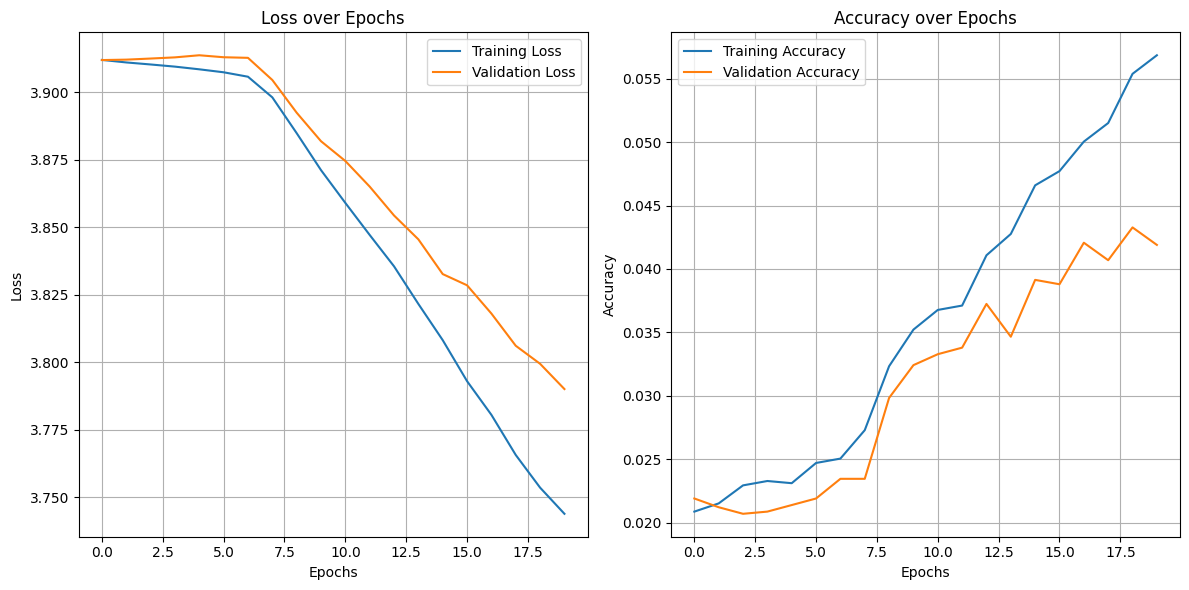

Generated music sequence: [48, 48, 48, 43, 43, 29, 43, 29, 43, 29, 21, 43, 21, 43, 21, 21, 43, 21, 25, 25, 25, 25, 25, 25, 25, 25, 15, 21, 15, 21, 35, 16, 19, 19, 28, 47, 5, 47, 47, 15, 15, 42, 12, 42, 12, 16, 15, 16, 14, 14]


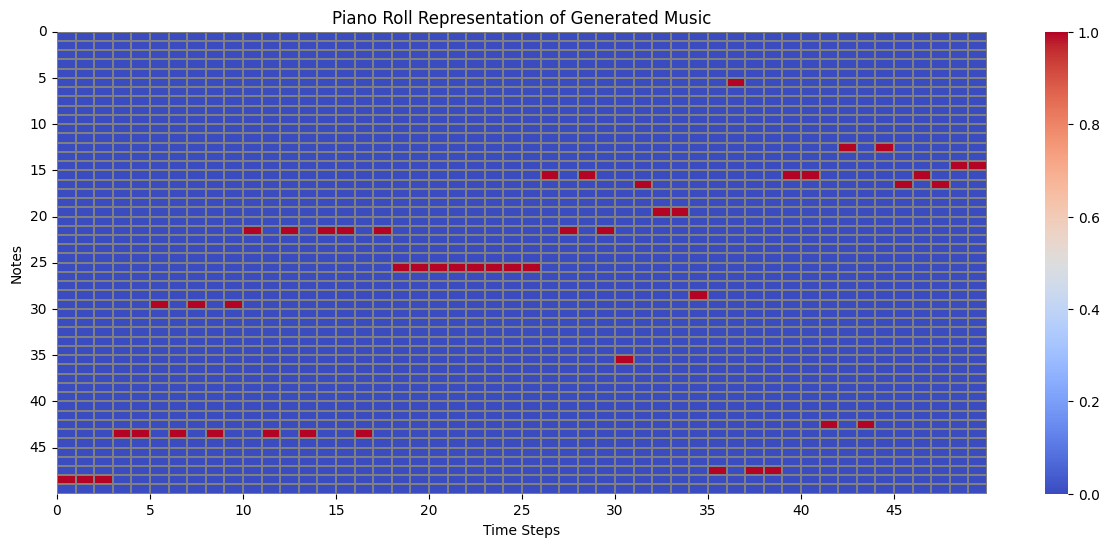

In [2]:
!pip install seaborn
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Data preparation
num_notes = 50
sequence_length = 30
num_sequences = 1000

np.random.seed(42)
data = np.random.randint(0, num_notes, size=(num_sequences, sequence_length))

x_train = data[:, :-1]
y_train = data[:, 1:]

# Model Parameters
embedding_dim = 32
latent_dim = 64

# Encoder
encoder_input = layers.Input(shape=(sequence_length - 1,))
embedding_layer = layers.Embedding(input_dim=num_notes, output_dim=embedding_dim, input_length=sequence_length - 1)
encoder_embedded = embedding_layer(encoder_input)
encoder_output, state_h, state_c = layers.LSTM(latent_dim, return_state=True)(encoder_embedded)

# Decoder
decoder_input = layers.Input(shape=(sequence_length - 1,))
decoder_embedded = embedding_layer(decoder_input)
decoder_lstm = layers.LSTM(latent_dim, return_sequences=True, return_state=False)
decoder_output = decoder_lstm(decoder_embedded, initial_state=[state_h, state_c])
decoder_dense = layers.TimeDistributed(layers.Dense(num_notes, activation='softmax'))
decoder_output = decoder_dense(decoder_output)

# Seq2Seq Model
seq2seq_model = models.Model([encoder_input, decoder_input], decoder_output)
seq2seq_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Prepare decoder input for teacher forcing
decoder_input_data = np.zeros_like(y_train)
decoder_input_data[:, 1:] = y_train[:, :-1]

# Train the model
history = seq2seq_model.fit(
    [x_train, decoder_input_data],
    y_train[:, :, np.newaxis],
    epochs=20,
    batch_size=64,
    validation_split=0.2
)

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Generate music
def generate_music_seq2seq(seq2seq_model, start_sequence, num_generated_notes):
    generated = []
    current_input = np.array(start_sequence).reshape(1, -1)

    for _ in range(num_generated_notes):
        # Predict next note probabilities
        pred = seq2seq_model.predict([current_input, current_input], verbose=0)
        next_note = np.argmax(pred[0, -1, :])
        generated.append(next_note)

        # Update input for the next step
        current_input = np.roll(current_input, -1)
        current_input[0, -1] = next_note

    return generated

# Use the first training sequence to generate music
start_sequence = x_train[0]
generated_music = generate_music_seq2seq(seq2seq_model, start_sequence, num_generated_notes=50)

# Visualization
def plot_piano_roll(generated_music, num_notes):
    piano_roll = np.zeros((num_notes, len(generated_music)))
    for t, note in enumerate(generated_music):
        piano_roll[note, t] = 1

    plt.figure(figsize=(15, 6))
    sns.heatmap(
        piano_roll,
        cmap="coolwarm",
        cbar=True,
        xticklabels=10,
        yticklabels=True,
        linewidths=0.1, linecolor='gray'
    )
    plt.title("Piano Roll Representation of Generated Music")
    plt.xlabel("Time Steps")
    plt.ylabel("Notes")
    plt.yticks(ticks=np.arange(0, num_notes, step=5), labels=np.arange(0, num_notes, step=5))
    plt.xticks(ticks=np.arange(0, len(generated_music), step=5), labels=np.arange(0, len(generated_music), step=5))
    plt.show()

print("Generated music sequence:", generated_music)
plot_piano_roll(generated_music, num_notes)
